In [1]:
!wget https://storage.googleapis.com/4995-dlcv-project-data/season_images.zip

--2023-12-08 01:42:03--  https://storage.googleapis.com/4995-dlcv-project-data/season_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5493694674 (5.1G) [application/zip]
Saving to: ‘season_images.zip’

season_images.zip   100%[===================>]   5.12G   117MB/s    in 49s     

2023-12-08 01:42:53 (106 MB/s) - ‘season_images.zip’ saved [5493694674/5493694674]



In [2]:
!wget https://storage.googleapis.com/4995-dlcv-project-data/season_captions.txt

--2023-12-08 01:42:53--  https://storage.googleapis.com/4995-dlcv-project-data/season_captions.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309502 (302K) [text/plain]
Saving to: ‘season_captions.txt’

season_captions.txt 100%[===================>] 302.25K  --.-KB/s    in 0.003s  

2023-12-08 01:42:53 (102 MB/s) - ‘season_captions.txt’ saved [309502/309502]



In [3]:
!mkdir -p "/content/season_images"

In [4]:
!unzip -q "/content/season_images.zip" -d "/content/season_images"

In [5]:
import os
from collections import defaultdict
import glob
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
# Use GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Use {DEVICE} device")

Use cuda device


## Data Processing

### CNN Image Encoding

In [7]:
class SeasonImageDataset(Dataset):
    def __init__(self, image_root, transform=None):
        self.image_root = image_root
        self.transform = transform
        self.image_ids = []
        for season in ['spring', 'summer', 'fall', 'winter']:
            abs_path = os.path.join(image_root, season)
            for img in os.listdir(abs_path):
                if img.endswith('.jpg'):
                    self.image_ids.append(img)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        if image_id.startswith('spring'):
            season = 'spring'
        elif image_id.startswith('summer'):
            season = 'summer'
        elif image_id.startswith('fall'):
            season = 'fall'
        else:
            season = 'winter'
        abs_path = os.path.join(self.image_root, season)
        image = Image.open(os.path.join(abs_path, image_id)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, image_id  # return image ID to keep track of images

    def __len__(self):
        return len(self.image_ids)

In [8]:
transform = transforms.Compose([
    transforms.Resize(299),  # required input size for InceptionV3
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Imagenet standards
])

In [9]:
# Load the dataset
season_dataset = SeasonImageDataset(image_root="/content/season_images", transform=transform)
season_data_loader = DataLoader(season_dataset, batch_size=32, shuffle=True)

In [10]:
print(len(season_dataset), len(season_data_loader))

24000 750


In [11]:
# Load the pre-trained InceptionV3 model and modify it for feature extraction
inception = models.inception_v3(pretrained=True)
inception.fc = torch.nn.Identity()
inception = inception.to('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Encode images
def encode_images(data_loader, model):
    model.eval()  # Set model to evaluation mode
    features_dict = {}
    for images, image_ids in tqdm(data_loader, desc='Encoding images'):
        images = images.to('cuda')
        with torch.no_grad():
            feature = model(images)
        # Convert features to CPU and numpy, then to a list
        feature_list = feature.cpu().detach().numpy().tolist()
        # Update dictionary with features
        for img_id, img_feature in zip(image_ids, feature_list):
            features_dict[img_id] = img_feature
    return features_dict

In [13]:
# Run the encoding
season_image_features = encode_images(season_data_loader, inception)

Encoding images: 100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


In [14]:
season_features_list = list(season_image_features.values())
season_ids_list = list(season_image_features.keys())

# Save features and IDs as numpy arrays
np.save('/content/season_features.npy', np.array(season_features_list))
np.save('/content/season_ids.npy', np.array(season_ids_list))

In [15]:
# Load the features and IDs
loaded_season_features_list = np.load('/content//season_features.npy', allow_pickle=True)
loaded_season_ids_list = np.load('/content/season_ids.npy', allow_pickle=True)
# Recreate the dictionary
loaded_season_features_dict = dict(zip(loaded_season_ids_list, loaded_season_features_list))

In [16]:
print(len(loaded_season_features_dict), list(loaded_season_features_dict.items())[0])

24000 ('fall_553.jpg', array([0.10395627, 0.25896969, 0.25952157, ..., 0.71366739, 0.59769624,
       0.19472916]))


### Caption Tokenization

In [17]:
# Create a dictionary that has image name as key and captions as value
def read_image_captions(filename):
    image_descriptions = defaultdict(list)
    with open(filename,'r') as file_list:
        for line in file_list:
            line = line.strip()
            img_caption_list = line.split(".jpg, ")
            img_name, captions = img_caption_list[0] + ".jpg", img_caption_list[1]
            caption_list = ["<START>"] + captions.lower().split(" ") + ["<END>"]
            image_descriptions[img_name].append(caption_list)
    return image_descriptions

In [18]:
descriptions = read_image_captions("/content/season_captions.txt")

In [19]:
print(descriptions["spring_4794.jpg"])

[['<START>', 'an', 'old', 'bridge', 'over', 'water', '<END>']]


In [20]:
image_names = list(loaded_season_features_dict.keys())

# 6000 train images (1500 for each season) and 1500 test images (375 for each season)
train_names = list(descriptions.keys())

existed_train = set(train_names)
remain = [name for name in image_names if name not in existed_train]
random.shuffle(image_names)
categorized_remain = defaultdict(list)
for img_name in remain:
    season, suffix = img_name.split('_')
    categorized_remain[season].append(img_name)
test_names = []
for key, value in categorized_remain.items():
    test_names += value[:375]

print(f"Train Images: {len(train_names)}, Test Images: {len(test_names)}")

Train Images: 6000, Test Images: 1500


In [21]:
# Create mapping for unique words in training data
train_tokens = set()
for name in train_names:
    captions = descriptions[name]
    for caption in captions:
        for token in caption:
            train_tokens.add(token)
TRAIN_VOCAB_SIZE = len(train_tokens)
train_tokens_sorted = sorted(list(train_tokens))

id_to_word = {}
word_to_id = {}
for i, token in enumerate(train_tokens_sorted):
    id_to_word[i] = token
    word_to_id[token] = i

print(f"Train Vocab Size: {TRAIN_VOCAB_SIZE}")

Train Vocab Size: 3048


In [22]:
print(word_to_id["flower"], id_to_word[998])

998 flower


### Dataset Preparation

In [23]:
# Subset train features and test features
train_features = {name: loaded_season_features_dict[name] for name in train_names}
test_features = {name: loaded_season_features_dict[name] for name in test_names}

In [24]:
MAX_LEN = max(len(description) for name in train_names for description in descriptions[name])
print("Maximum length of a sequence: ", MAX_LEN)

Maximum length of a sequence:  27


In [25]:
class ImageCaptionDataset(Dataset):
    def __init__(self, name_list, descriptions, word_to_id, img_encodings, max_len, vocab_size):
        self.data = []
        self.vocab_size = vocab_size
        self.max_len = max_len

        for img_name in name_list:
            img_encoding = img_encodings[img_name]
            captions = descriptions[img_name]
            for caption in captions:
                for i in range(1, len(caption)):
                    encoded_input = [word_to_id[w] for w in caption[:i]]
                    # If input sequence is shorter than max_len, pad remaining entries with 0
                    if len(encoded_input) < max_len:
                        encoded_input += [0] * (max_len - len(encoded_input))
                    encoded_output = word_to_id[caption[i]]
                    self.data.append((img_encoding, encoded_input, encoded_output))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_input, text_input, output_word = self.data[idx]
        return torch.tensor(img_input, dtype=torch.float), torch.tensor(text_input, dtype=torch.long), torch.tensor(output_word, dtype=torch.long)

In [26]:
# Create train datasets and data loader
train_dataset = ImageCaptionDataset(train_names, descriptions, word_to_id, train_features, MAX_LEN, TRAIN_VOCAB_SIZE)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Image Captioning Model

### Training

In [27]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_enc_dim, hidden_dim, max_len):
        super(ImageCaptioningModel, self).__init__()

        # CNN Feature components
        self.cnn_dense = nn.Linear(2048, image_enc_dim)
        self.cnn_dropout = nn.Dropout(0.5)

        # LSTM Sequence components
        self.seq_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.seq_dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Decoder components
        self.decoder_dense = nn.Linear(hidden_dim + image_enc_dim, 256)  # Size is doubled due to concatenation
        self.final_output = nn.Linear(256, vocab_size)

    def forward(self, cnn_input, seq_input):
        # CNN Feature processing
        cnn_output = self.cnn_dropout(cnn_input)
        cnn_output = nn.ReLU()(self.cnn_dense(cnn_output))

        # LSTM Sequence processing
        seq_embedded = self.seq_embedding(seq_input)
        seq_dropped = self.seq_dropout(seq_embedded)
        _, (seq_output, _) = self.lstm(seq_dropped)

        # Merge CNN and LSTM outputs
        merged_outputs = torch.cat((cnn_output, seq_output.squeeze(0)), dim=1)

        # Decoder
        decoder_output = nn.ReLU()(self.decoder_dense(merged_outputs))
        final_output = self.final_output(decoder_output)

        return final_output

In [28]:
# Define model parameters
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
IMAGE_ENC_DIM = 256

# Instantiate the ImageCaptioningModel
model = ImageCaptioningModel(TRAIN_VOCAB_SIZE, EMBEDDING_DIM, IMAGE_ENC_DIM, HIDDEN_DIM, MAX_LEN).to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Softmax activation for probability distribution
softmax = nn.Softmax(dim=1)

In [29]:
# Training loop
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_count = 0

    for img_inputs, text_inputs, targets in train_loader:
        img_inputs, text_inputs, targets = img_inputs.to(DEVICE), text_inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(img_inputs, text_inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(targets)
        pred = softmax(outputs)
        train_corrects += (torch.argmax(pred, dim=1) == targets).float().sum()
        train_count += targets.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects / train_count

    print(f"Epoch {epoch} Train Loss {train_loss:.4f} Train Accuracy {train_acc:.4f} ")
torch.save(model.state_dict(), './season_image_captioning_model.pth')

Epoch 0 Train Loss 4.8501 Train Accuracy 0.1659 
Epoch 1 Train Loss 4.3029 Train Accuracy 0.2034 
Epoch 2 Train Loss 4.0356 Train Accuracy 0.2239 
Epoch 3 Train Loss 3.7150 Train Accuracy 0.2575 
Epoch 4 Train Loss 3.4719 Train Accuracy 0.2857 
Epoch 5 Train Loss 3.2657 Train Accuracy 0.3051 
Epoch 6 Train Loss 3.1004 Train Accuracy 0.3219 
Epoch 7 Train Loss 2.9578 Train Accuracy 0.3339 
Epoch 8 Train Loss 2.8279 Train Accuracy 0.3449 
Epoch 9 Train Loss 2.7374 Train Accuracy 0.3505 
Epoch 10 Train Loss 2.6165 Train Accuracy 0.3610 
Epoch 11 Train Loss 2.5250 Train Accuracy 0.3704 
Epoch 12 Train Loss 2.4443 Train Accuracy 0.3773 
Epoch 13 Train Loss 2.3693 Train Accuracy 0.3840 
Epoch 14 Train Loss 2.3009 Train Accuracy 0.3929 


In [30]:
# Load the best model
model.load_state_dict(torch.load('./season_image_captioning_model.pth'))

<All keys matched successfully>

### Evaluation

In [34]:
# Generate image captions using the trained model
def image_decoder(model, img_encodings):
    img_encodings = np.array(img_encodings)
    img_encodings = torch.tensor([img_encodings], dtype=torch.float).to(DEVICE)
    seq = ["<START>"]
    while len(seq) < MAX_LEN and seq[-1] != "<END>":
        text_encodings = [word_to_id[w] for w in seq]
        if len(text_encodings) < MAX_LEN:
            text_encodings += [0] * (MAX_LEN - len(text_encodings))
        text_encodings = torch.tensor([text_encodings]).to(DEVICE)
        outputs = model(img_encodings, text_encodings)
        probs = softmax(outputs).squeeze(0).cpu()
        pred_word = id_to_word[torch.argmax(probs).item()]
        seq.append(pred_word)
    return seq

In [35]:
SEASON_DIR = "/content/season_images"

#### Generate captions on training images

<START> a tree with pink flowers <END>


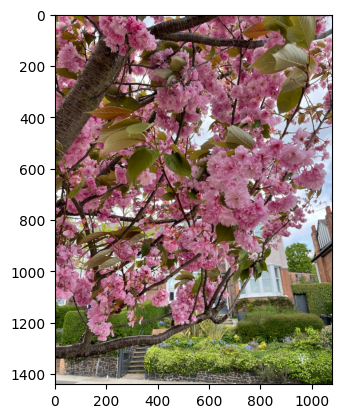

In [36]:
# Test using spring image
season = "spring"
img_name = "spring_2077.jpg"
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> a field with a farm <END>


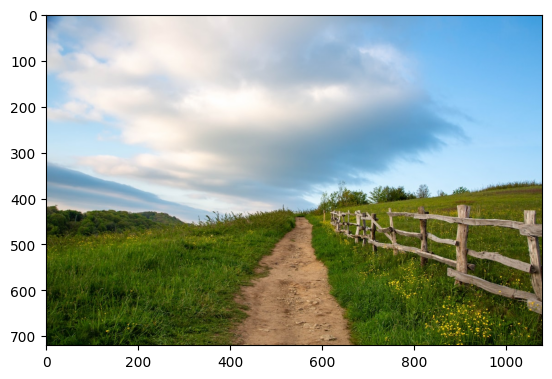

In [40]:
# Test using spring image
season = "spring"
img_name = "spring_358.jpg"
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> a woman in the sun <END>


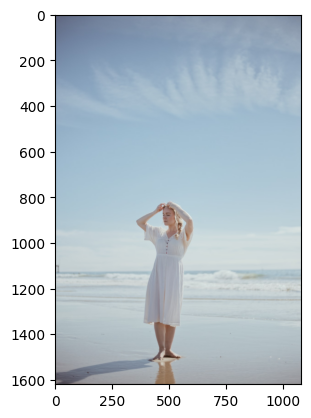

In [46]:
# Test using summer image
season = "summer"
img_name = "summer_4961.jpg"
SUMMER_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SUMMER_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> a palm tree against a blue sky <END>


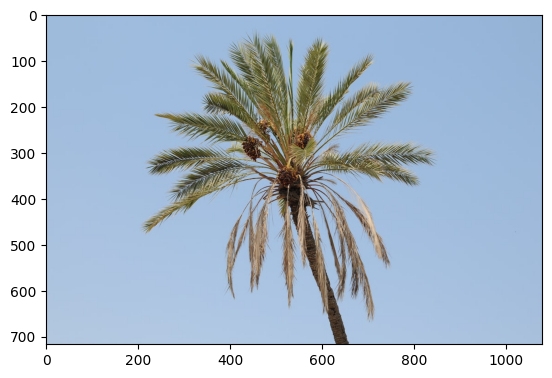

In [47]:
# Test using summer image
season = "summer"
img_name = "summer_3487.jpg"
SUMMER_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SUMMER_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> pumpkins in rows <END>


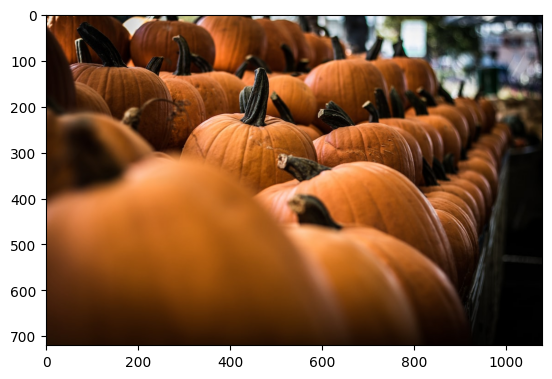

In [49]:
# Test using fall image
season = "fall"
img_name = "fall_743.jpg"
FALL_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(FALL_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> autumn leaves on the ground <END>


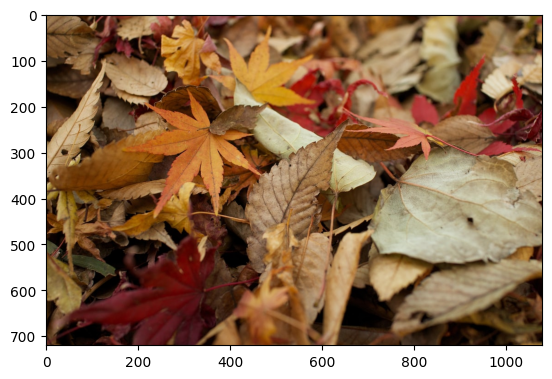

In [50]:
# Test using fall image
season = "fall"
img_name = "fall_286.jpg"
FALL_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(FALL_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> a person walking in the snow <END>


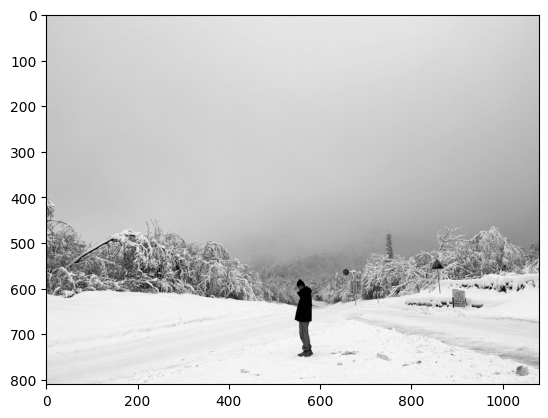

In [51]:
# Test using winter image
season = "winter"
img_name = "winter_3037.jpg"
WINTER_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(WINTER_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

<START> a snowman in the snow <END>


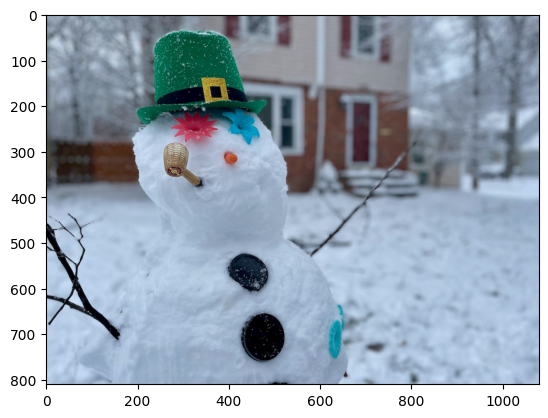

In [54]:
# Test using winter image
season = "winter"
img_name = "winter_4505.jpg"
WINTER_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(WINTER_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(" ".join(generated_caption))
plt.imshow(image)

#### Generate captions on testing images

In [55]:
# Test using spring image
spring_test_names = []
for name in test_names:
    if name.startswith("spring"):
        spring_test_names.append(name)

spring_3923.jpg
<START> a small church in the background <END>


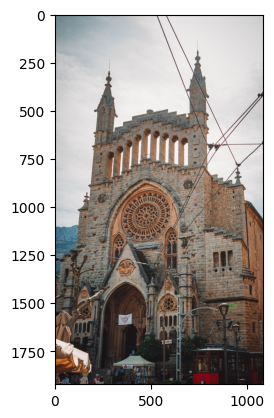

In [225]:
season = "spring"
img_name = spring_test_names[70]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

spring_2057.jpg
<START> a flowering tree with a blue sky <END>


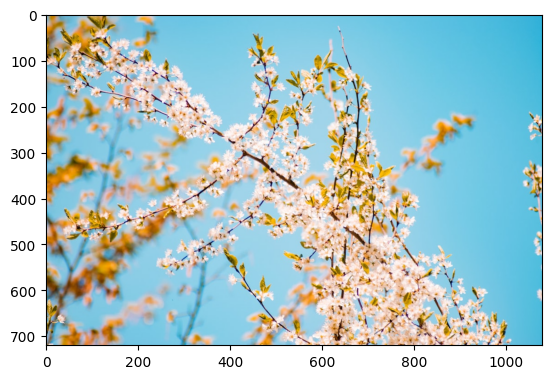

In [226]:
season = "spring"
img_name = spring_test_names[109]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

spring_3761.jpg
<START> a white flower with blurry petals <END>


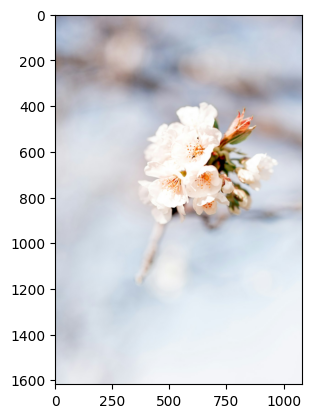

In [236]:
season = "spring"
img_name = spring_test_names[215]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

spring_1070.jpg
<START> a butterfly flying in the leaves <END>


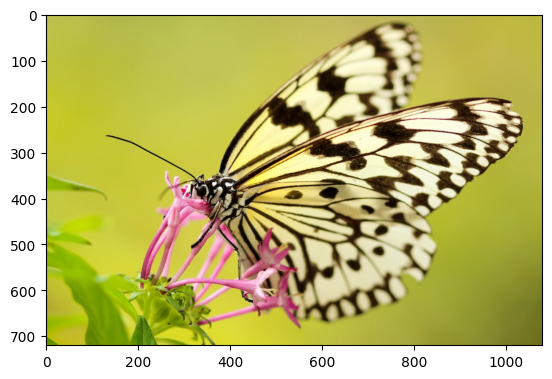

In [237]:
season = "spring"
img_name = spring_test_names[362]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

In [85]:
# Test using summer image
summer_test_names = []
for name in test_names:
    if name.startswith("summer"):
        summer_test_names.append(name)

summer_4388.jpg
<START> a coffee cup <END>


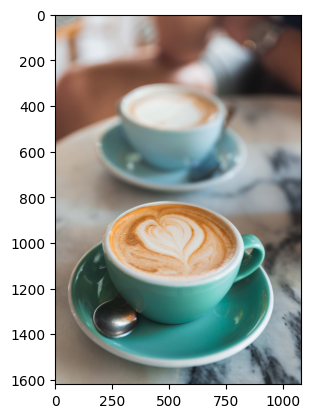

In [240]:
season = "summer"
img_name = summer_test_names[19]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

summer_2428.jpg
<START> some flowers with blue sky <END>


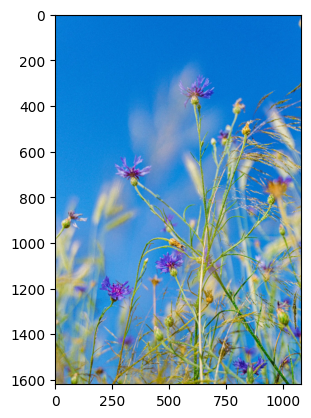

In [241]:
season = "summer"
img_name = summer_test_names[115]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

summer_4881.jpg
<START> a beach with palm trees <END>


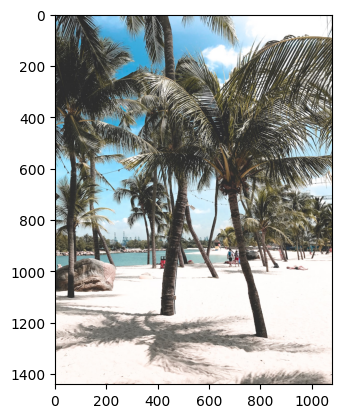

In [242]:
season = "summer"
img_name = summer_test_names[241]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

summer_1471.jpg
<START> a beach with umbrellas on the beach <END>


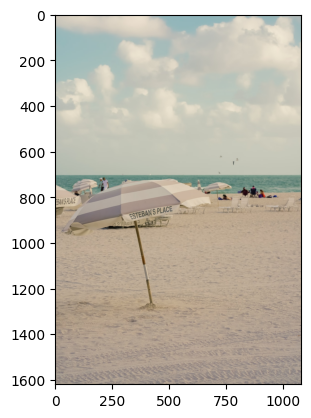

In [245]:
season = "summer"
img_name = summer_test_names[304]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

In [127]:
# Test using fall image
fall_test_names = []
for name in test_names:
    if name.startswith("fall"):
        fall_test_names.append(name)

fall_500.jpg
<START> a person walking through a forest <END>


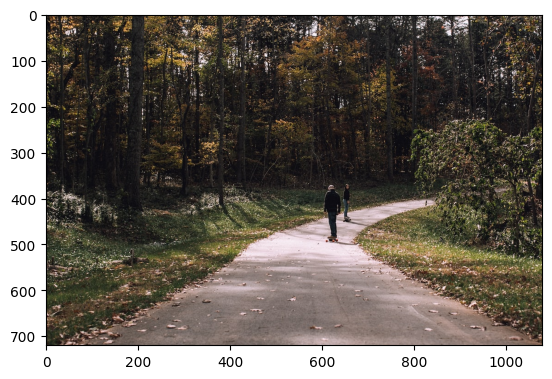

In [246]:
season = "fall"
img_name = fall_test_names[71]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

fall_5490.jpg
<START> autumn leaves in the shade <END>


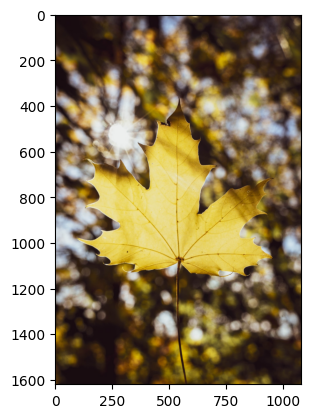

In [247]:
season = "fall"
img_name = fall_test_names[123]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

fall_5793.jpg
<START> a bunch of autumn leaves <END>


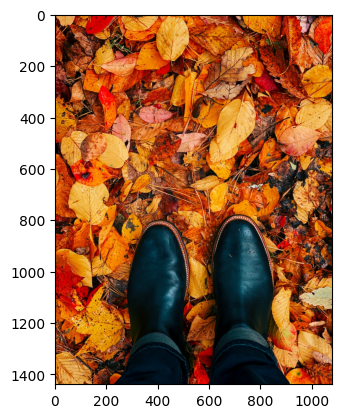

In [252]:
season = "fall"
img_name = fall_test_names[264]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

fall_3551.jpg
<START> a bush with red berries <END>


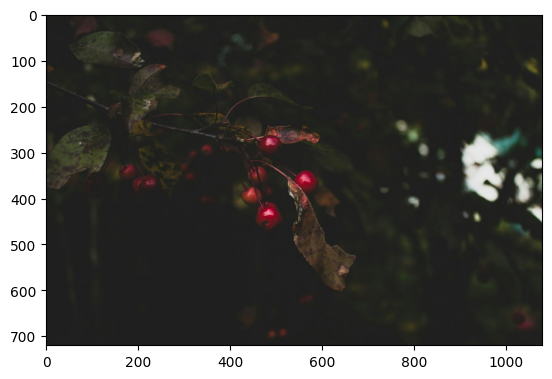

In [260]:
season = "fall"
img_name = fall_test_names[345]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

In [160]:
# Test using winter image
winter_test_names = []
for name in test_names:
    if name.startswith("winter"):
        winter_test_names.append(name)

winter_1843.jpg
<START> snow covered trees in the snow <END>


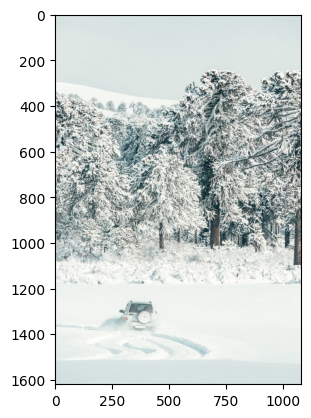

In [261]:
season = "winter"
img_name = winter_test_names[44]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

winter_4170.jpg
<START> a woman in the snow <END>


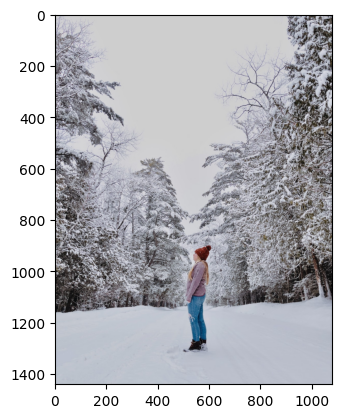

In [262]:
season = "winter"
img_name = winter_test_names[162]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

winter_2532.jpg
<START> a house in the middle of a snow covered mountain <END>


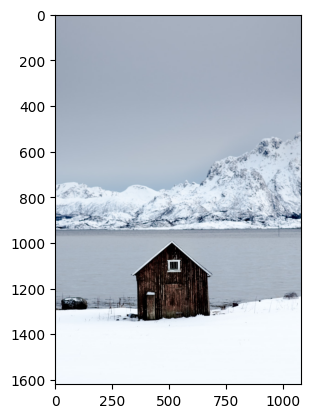

In [263]:
season = "winter"
img_name = winter_test_names[206]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)

winter_930.jpg
<START> a snowy mountain <END>


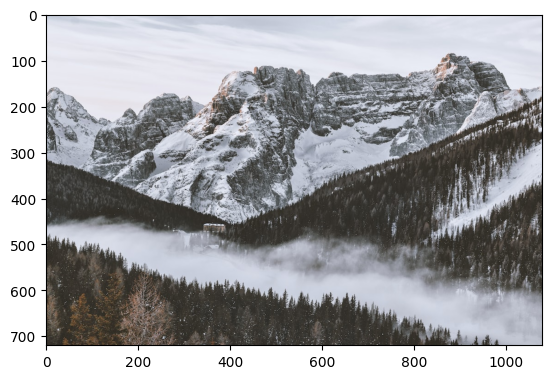

In [271]:
season = "winter"
img_name = winter_test_names[369]
SPRING_DIR = os.path.join(SEASON_DIR, season)
img_path = os.path.join(SPRING_DIR, img_name)
img_enc = loaded_season_features_dict[img_name]
image = Image.open(img_path)
generated_caption = image_decoder(model, img_enc)
print(img_name)
print(" ".join(generated_caption))
plt.imshow(image)